# Forecasting with an RNN

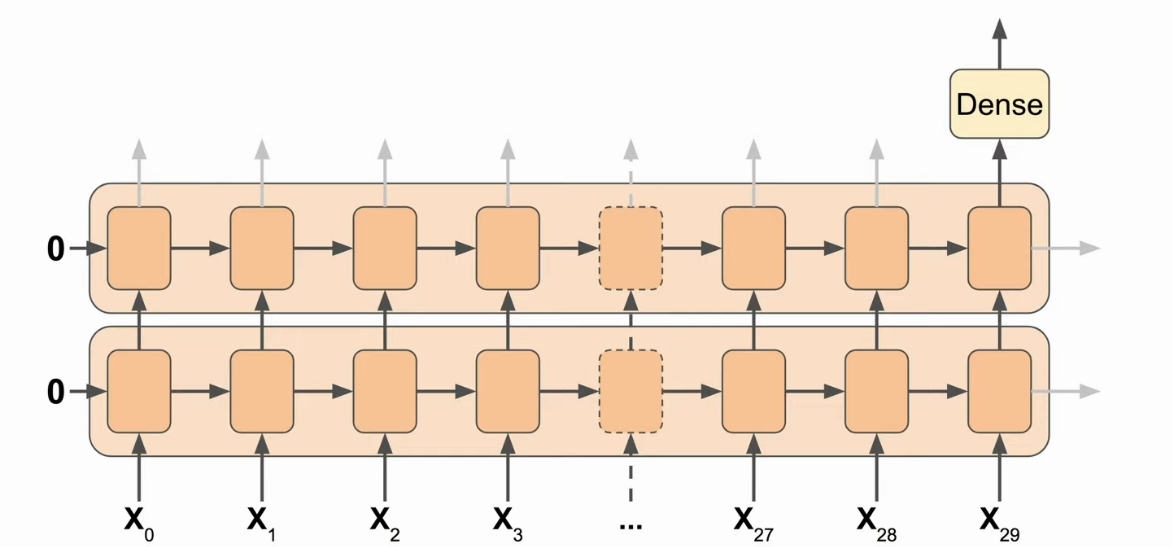

* Instable gradients, can vanish or explode. Using relu is not really good as it is non saturating.

* 3 dimensions input -> (batch, steps, output)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/energydata_complete.csv")

In [3]:
ts = df["Appliances"]

In [4]:
ts.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [5]:
dates = pd.to_datetime(df.date)

In [6]:
series = np.asarray(ts.values)

In [7]:
time = np.arange(series.shape[0])

In [8]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [9]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 20000):
    dataset = tf.data.Dataset.from_tensor_slices(series) #instead of random values we are doing it with the data
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size = shuffle_buffer) #IID gd works best #buffersize must be greater or equal to the number of examples
    dataset = dataset.batch(batch_size).prefetch(1) # you probably will want bigger batchs like 32 / 64
    return dataset

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

In [11]:
split_time = int(series.shape[0] * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN

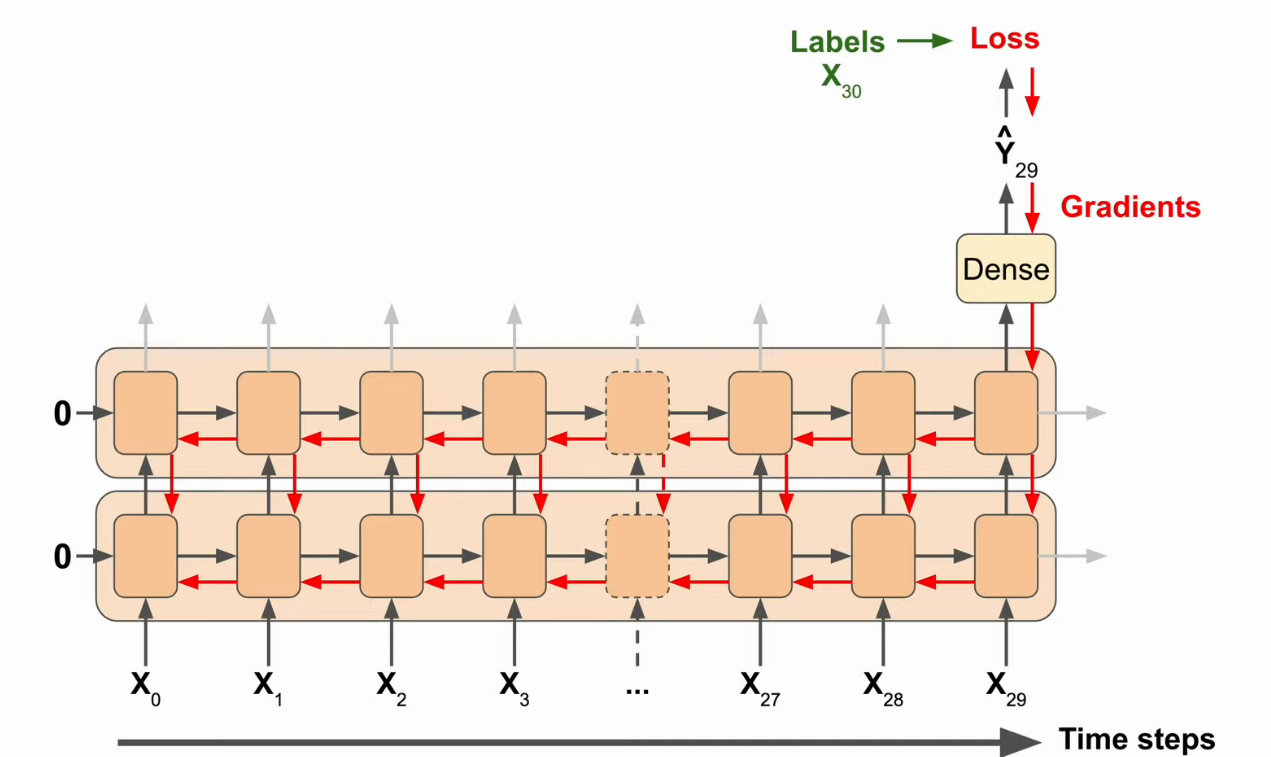
* Backprop

* You have to guess a good learning rate. If too high it wont learn ok, too low will take too much time.

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x : tf.expand_dims(x, axis = -1),
                       input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch/20))

optimizer = keras.optimizers.Adam()

model.compile(loss=keras.losses.mean_squared_error,
             optimizer=optimizer,
             metrics=["mae","mse"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
124/124 [==============================] - 6s 50ms/step - loss: 10687.2246 - mae: 74.2607 - mse: 10740.3525
Epoch 2/100
124/124 [==============================] - 5s 43ms/step - loss: 10568.1808 - mae: 71.7240 - mse: 10556.0859
Epoch 3/100
124/124 [==============================] - 5s 41ms/step - loss: 10350.5546 - mae: 69.1304 - mse: 10389.8271
Epoch 4/100
124/124 [==============================] - 5s 44ms/step - loss: 10208.6806 - mae: 66.5915 - mse: 10246.8818
Epoch 5/100
124/124 [==============================] - 5s 43ms/step - loss: 10075.1459 - mae: 64.2257 - mse: 10126.7461
Epoch 6/100
124/124 [==============================] - 5s 42ms/step - loss: 9977.5785 - mae: 62.1729 - mse: 10025.6455
Epoch 7/100
124/124 [==============================] - 5s 41ms/step - loss: 9930.0862 - mae: 60.3490 - mse: 9939.2021
Epoch 8/100
124/124 [==============================] - 5s 42ms/step - loss: 9903.7333 - mae: 58.9975 - mse: 9860.6758
Epoch 9/100
124/124 [========================

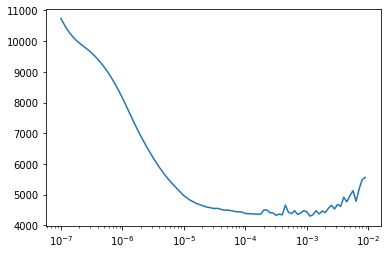

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])

* $10^{-4}$ seems to be the best learning rate

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x : tf.expand_dims(x, axis = -1),
                       input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.Adam(learning_rate=1e-4)

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5",
                                                    save_best_only=True)

model.compile(loss=keras.losses.mean_squared_error,
             optimizer=optimizer,
             metrics=["mae","mse"])
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
124/124 [==============================] - 8s 61ms/step - loss: 7233.7570 - mae: 44.9067 - mse: 7283.1055 - val_loss: 4196.6807 - val_mae: 32.0597 - val_mse: 4165.1665
Epoch 2/500
124/124 [==============================] - 6s 48ms/step - loss: 5062.5443 - mae: 33.4518 - mse: 5065.5488 - val_loss: 3604.0298 - val_mae: 27.2205 - val_mse: 3610.6624
Epoch 3/500
124/124 [==============================] - 6s 49ms/step - loss: 4725.7546 - mae: 31.5704 - mse: 4718.0435 - val_loss: 3582.2481 - val_mae: 25.9298 - val_mse: 3540.8525
Epoch 4/500
124/124 [==============================] - 6s 49ms/step - loss: 4589.7457 - mae: 31.4120 - mse: 4604.5029 - val_loss: 3418.9612 - val_mae: 25.6990 - val_mse: 3447.7029
Epoch 5/500
124/124 [==============================] - 6s 50ms/step - loss: 4521.1104 - mae: 31.3328 - mse: 4539.2866 - val_loss: 3538.6134 - val_mae: 26.6529 - val_mse: 3552.5608
Epoch 6/500
124/124 [==============================] - 6s 50ms/step - loss: 4476.0598 - mae: 30.8947

In [14]:
model = keras.models.load_model("best_model.h5")

In [15]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

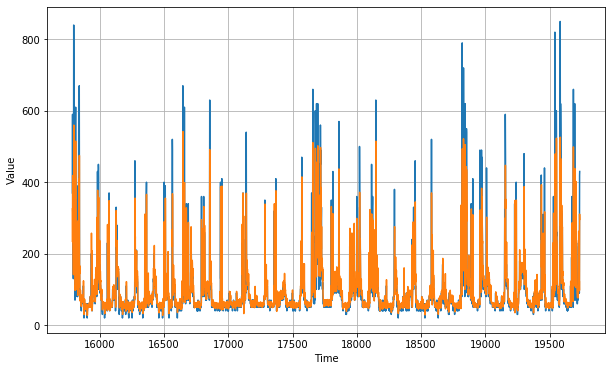

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()

3438.8645

In [18]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

26.293917

* It is now our best model, outperformed the two relu dense layers

## Stateless and Stateful RNNS

* Stateless can only learn in the window length
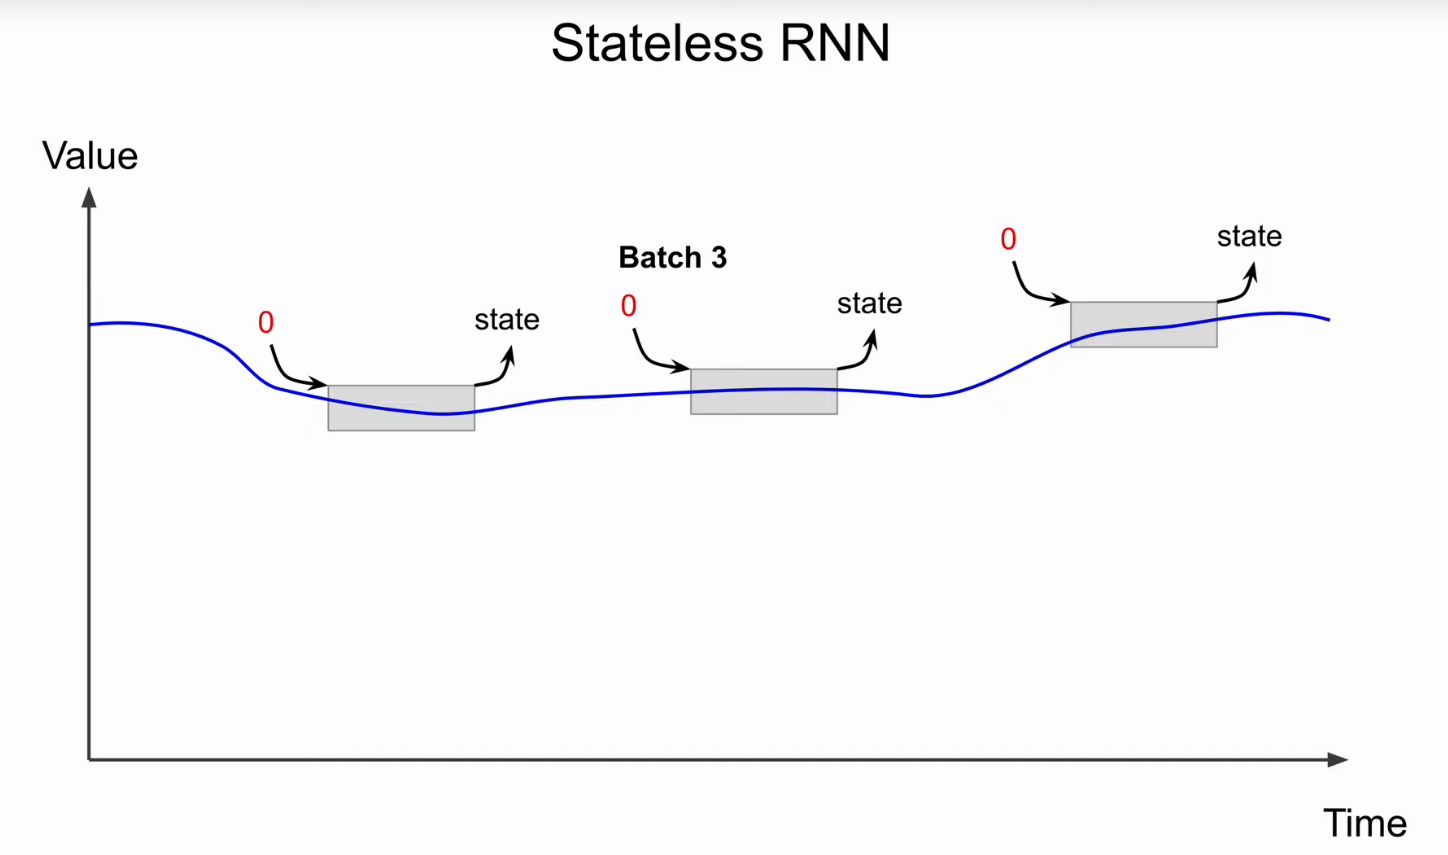

* Stateful -> the output state is not dropped, it is used by the next training example. It helps to learn long term patterns. Although, it is trickier and have some more downsides, it is not commonly used, but can perform better in some cases.
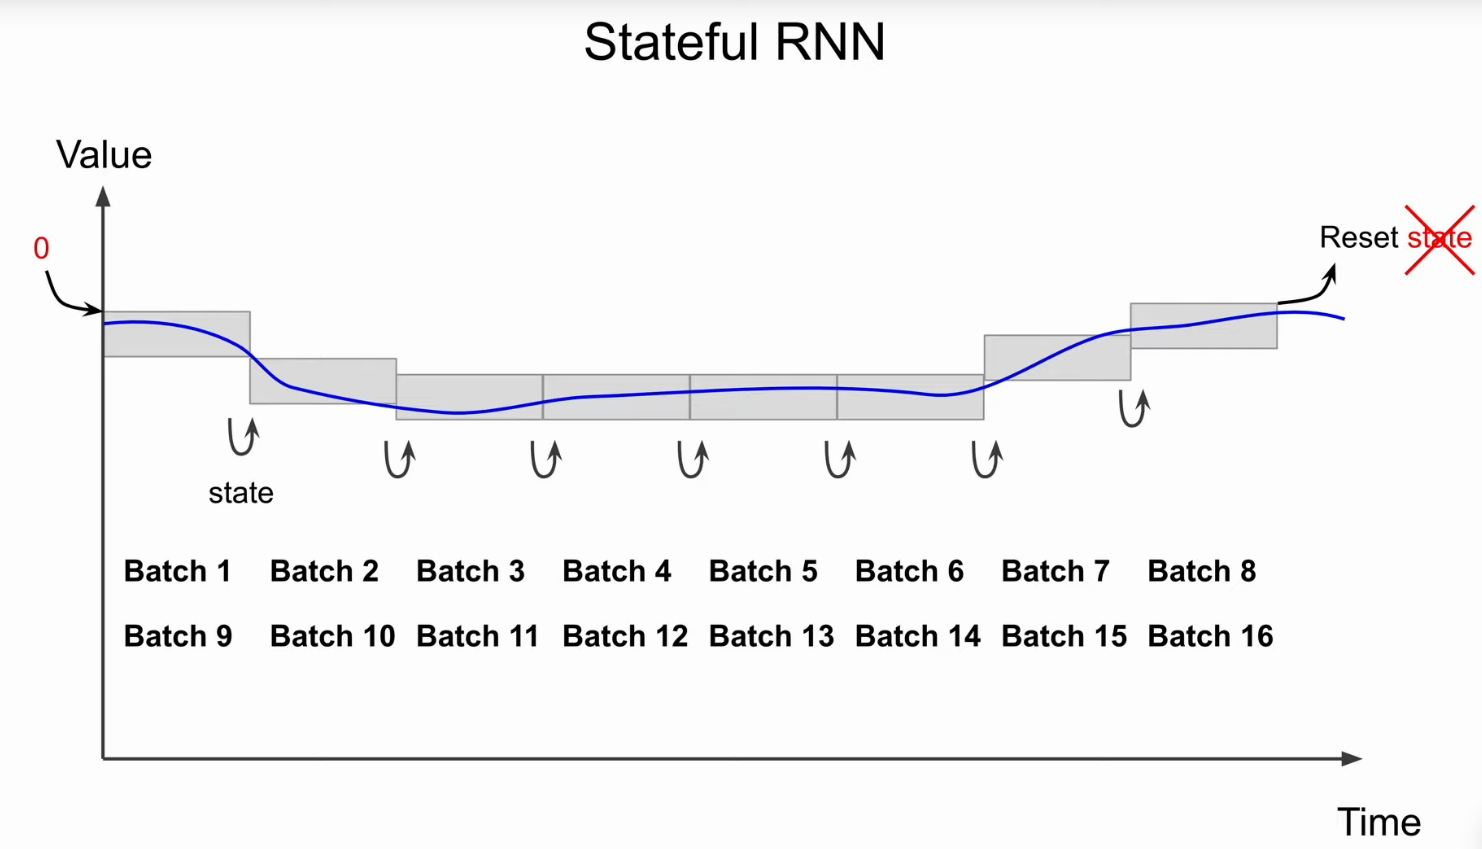